- Processamento básico de imagens
- Detecção e segmentação
- Extração de características
- Transformações geométricas
- Aplicação de IA/ML para classificação de imagens

Utiliza o conjunto de dados CIFAR-10 para demonstrar as técnicas.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical

## 1. Processamento de Imagens

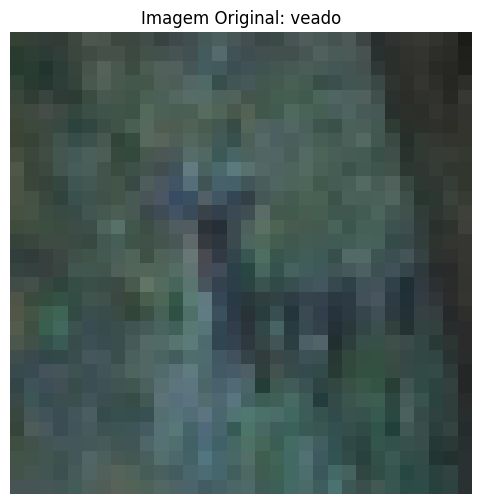

In [16]:
# Carrega imagens do CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Classes no CIFAR-10
class_names = ['avião', 'automóvel', 'pássaro', 'gato', 'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# Função para exibir imagens
def exibir_imagens(imagens, titulos=None, cmap=None):
    plt.figure(figsize=(15, 6))
    num_imagens = len(imagens)
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i+1)
        plt.imshow(imagens[i], cmap=cmap)
        if titulos is not None:
            plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Seleciona uma imagem de exemplo
imagem_original = x_train[10]
imagem_rgb = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB)
imagem_gray = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

# Exibe a imagem original
plt.figure(figsize=(6, 6))
plt.imshow(imagem_rgb)
plt.title(f'Imagem Original: {class_names[y_train[10][0]]}')
plt.axis('off')
plt.show()

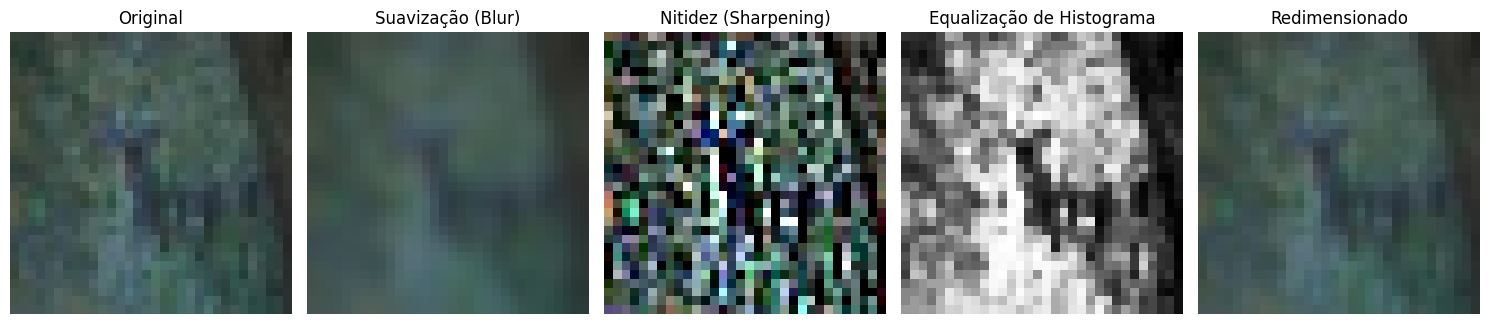

In [17]:
# Aplica diferentes técnicas de pré-processamento

# 1. Suavização (Blur)
blur = cv2.GaussianBlur(imagem_rgb, (5, 5), 0)

# 2. Nitidez (Sharpening)
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(imagem_rgb, -1, kernel_sharpening)

# 3. Equalização de histograma (em escala de cinza)
eq_hist = cv2.equalizeHist(imagem_gray)
eq_hist_rgb = cv2.cvtColor(eq_hist, cv2.COLOR_GRAY2RGB)

# 4. Redimensionamento
resized = cv2.resize(imagem_rgb, (64, 64))
resized = cv2.resize(resized, (32, 32))  # Voltando ao tamanho original

# Exibe os resultados
exibir_imagens(
    [imagem_rgb, blur, sharpened, eq_hist_rgb, resized],
    ['Original', 'Suavização (Blur)', 'Nitidez (Sharpening)', 'Equalização de Histograma', 'Redimensionado']
)

## 2. Detecção e Segmentação

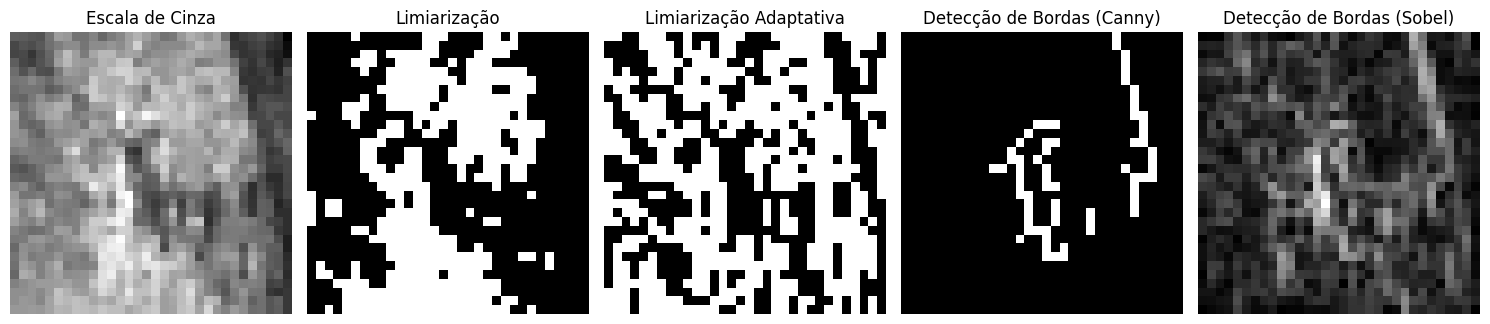

In [18]:
# Converte para escala de cinza (se ainda não estiver)
if len(imagem_gray.shape) > 2:
    imagem_gray = cv2.cvtColor(imagem_gray, cv2.COLOR_BGR2GRAY)

# 1. Segmentação por limiarização (thresholding)
ret, thresh = cv2.threshold(imagem_gray, 80, 255, cv2.THRESH_BINARY)

# 2. Limiarização adaptativa
thresh_adaptive = cv2.adaptiveThreshold(imagem_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

# 3. Detecção de bordas usando Canny
edges_canny = cv2.Canny(imagem_gray, 100, 200)

# 4. Detecção de bordas usando Sobel
sobelx = cv2.Sobel(imagem_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(imagem_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)
sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Exibe os resultados
exibir_imagens(
    [imagem_gray, thresh, thresh_adaptive, edges_canny, sobel_combined],
    ['Escala de Cinza', 'Limiarização', 'Limiarização Adaptativa', 'Detecção de Bordas (Canny)', 'Detecção de Bordas (Sobel)'],
    cmap='gray'
)

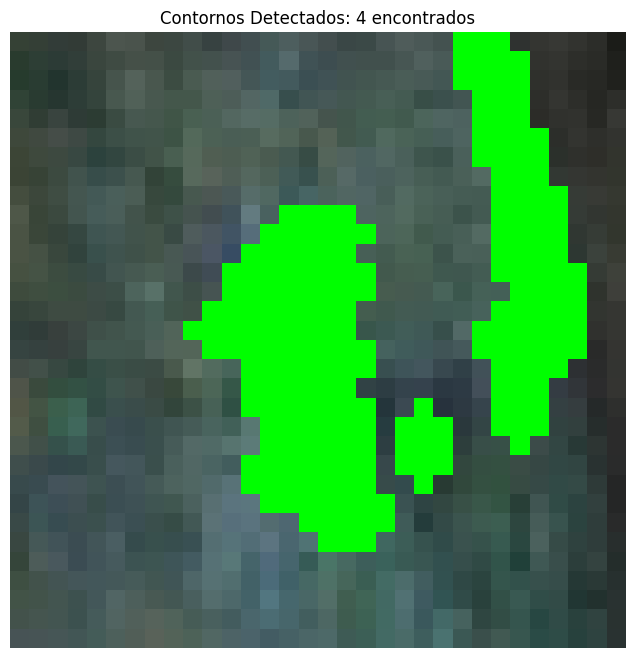

In [19]:
# Encontra contornos a partir da detecção de bordas
contours, hierarchy = cv2.findContours(edges_canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenha os contornos na imagem original
contour_img = imagem_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Exibe a imagem com contornos
plt.figure(figsize=(8, 8))
plt.imshow(contour_img)
plt.title(f'Contornos Detectados: {len(contours)} encontrados')
plt.axis('off')
plt.show()

## 3. Extração de Características

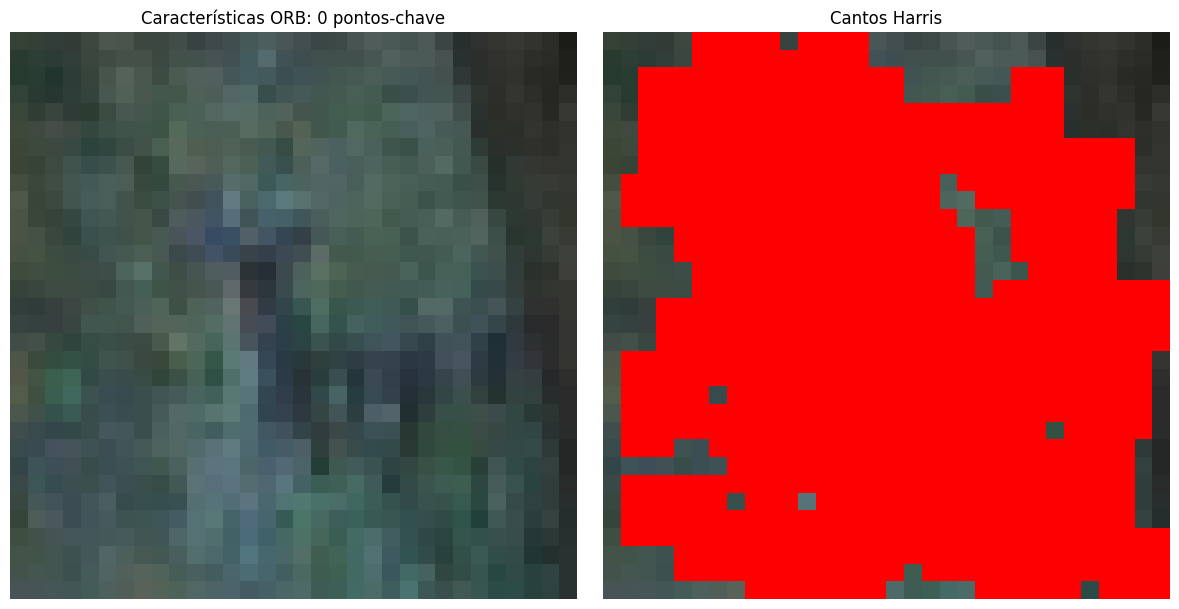

In [20]:
# Converte a imagem para formato adequado para detectores de características
img_for_features = imagem_gray.astype(np.uint8)

# 1. Detecta características ORB (Oriented FAST and Rotated BRIEF)
orb = cv2.ORB_create(nfeatures=100)
keypoints_orb, descriptors_orb = orb.detectAndCompute(img_for_features, None)

# 2. Detecta cantos Harris
harris_corners = cv2.cornerHarris(np.float32(img_for_features), 2, 3, 0.04)
harris_corners = cv2.dilate(harris_corners, None)

# Desenha os keypoints detectados pelo ORB
img_keypoints_orb = cv2.drawKeypoints(imagem_rgb, keypoints_orb, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Cria uma imagem para mostrar os cantos Harris
img_harris = imagem_rgb.copy()
threshold = 0.01 * harris_corners.max()
img_harris[harris_corners > threshold] = [255, 0, 0]

# Exibe os resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_keypoints_orb)
plt.title(f'Características ORB: {len(keypoints_orb)} pontos-chave')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_harris)
plt.title('Cantos Harris')
plt.axis('off')

plt.tight_layout()
plt.show()

### Uso das Características para Classificação ou Comparação

Os descritores extraídos com ORB poderiam ser usados para:

1. Comparação de imagens:
   - Calcular descritores para pares de imagens e usar algoritmos como BFMatcher para encontrar correspondências.
   - A quantidade de correspondências boas pode indicar a similaridade entre as imagens.

2. Classificação de imagens:
   - Extrair descritores de um conjunto de imagens de treinamento.
   - Criar um histograma de palavras visuais (Bag of Visual Words).
   - Treinar um classificador (como SVM) usando esses histogramas.
   - Classificar novas imagens baseado em seus histogramas de palavras visuais.

## 4. Transformações Geométricas e Homografia

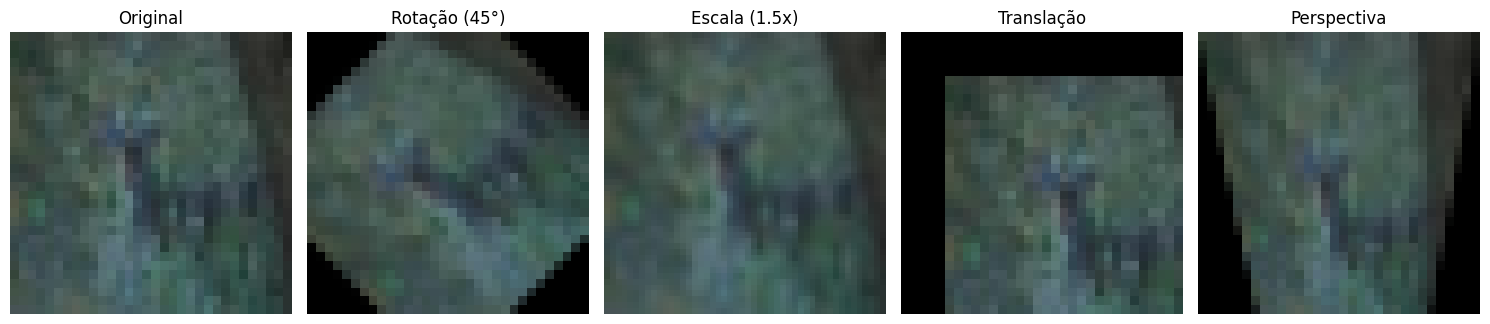

In [21]:
# Usa a imagem original para aplicar transformações
img_transform = imagem_rgb.copy()
height, width = img_transform.shape[:2]

# 1. Rotação
matriz_rotacao = cv2.getRotationMatrix2D((width/2, height/2), 45, 1)
img_rotacionada = cv2.warpAffine(img_transform, matriz_rotacao, (width, height))

# 2. Escala (redimensionamento)
img_escala = cv2.resize(img_transform, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

# 3. Translação
matriz_translacao = np.float32([[1, 0, 5], [0, 1, 5]])
img_translacao = cv2.warpAffine(img_transform, matriz_translacao, (width, height))

# 4. Transformação de perspectiva
pts1 = np.float32([[0, 0], [width-1, 0], [0, height-1], [width-1, height-1]])
pts2 = np.float32([[0, 0], [width-1, 0], [width*0.2, height-1], [width*0.8, height-1]])
matriz_perspectiva = cv2.getPerspectiveTransform(pts1, pts2)
img_perspectiva = cv2.warpPerspective(img_transform, matriz_perspectiva, (width, height))

# Exibe resultados
exibir_imagens(
    [img_transform, img_rotacionada, img_escala, img_translacao, img_perspectiva],
    ['Original', 'Rotação (45°)', 'Escala (1.5x)', 'Translação', 'Perspectiva']
)

### Criação de um Panorama (Exemplo Simplificado)

Imagens locais carregadas com sucesso: imagens\10.jpg e imagens\11.jpg


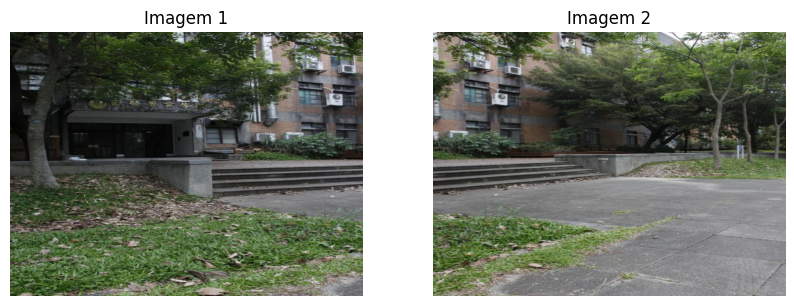

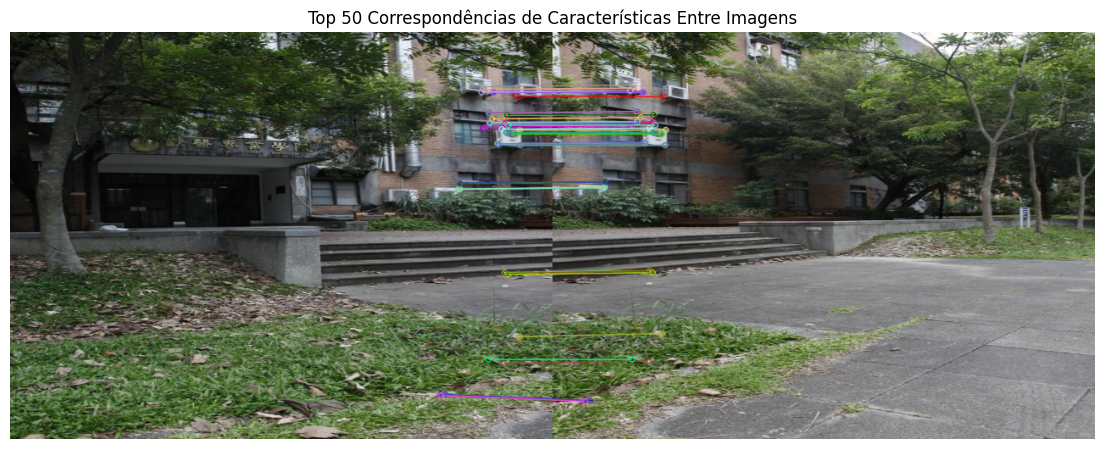

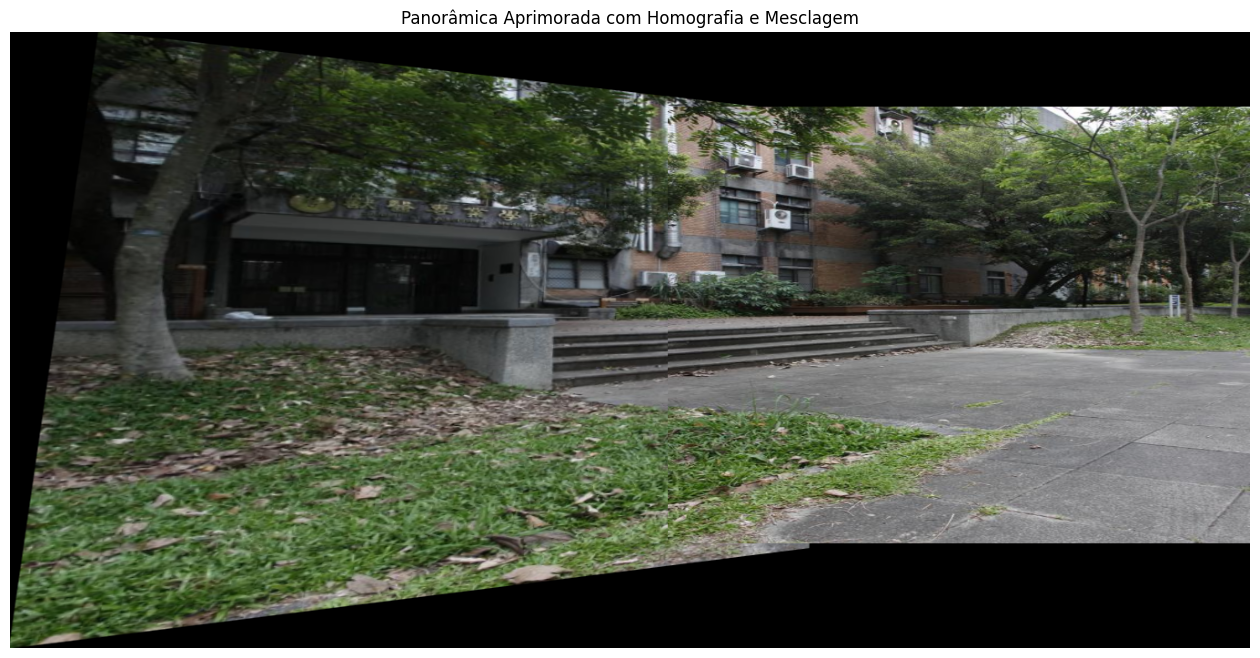

In [22]:
local_image1 = 'imagens\\10.jpg'
local_image2 = 'imagens\\11.jpg'

try:
    img1 = cv2.imread(local_image1)
    img2 = cv2.imread(local_image2)
    
    # Verifica se as imagens foram carregadas corretamente
    if img1 is None or img2 is None:
        raise Exception("Falha ao carregar imagens locais")
        
    # Redimensiona as imagens se forem muito grandes
    if img1.shape[0] > 480 or img1.shape[1] > 640:
        img1 = cv2.resize(img1, (640, 480))
    if img2.shape[0] > 480 or img2.shape[1] > 640:
        img2 = cv2.resize(img2, (640, 480))
        
    print(f"Imagens locais carregadas com sucesso: {local_image1} e {local_image2}")
except Exception as e:
    print(f"Erro ao carregar imagens locais: {e}")
    # Alternativa para imagens do CIFAR
    ship1_idx, ship2_idx = 8, 9
    img1 = cv2.resize(x_train[ship1_idx], (320, 240), interpolation=cv2.INTER_CUBIC)
    img2 = cv2.resize(x_train[ship2_idx], (320, 240), interpolation=cv2.INTER_CUBIC)

# Mostra as imagens para confirmar que foram carregadas corretamente
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Imagem 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Imagem 2")
plt.axis('off')
plt.show()

# Converte as imagens para tons de cinza para detecção de características
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Converte para RGB para visualização
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Extrai as características usando ORB (Oriented FAST e Rotated BRIEF)
orb = cv2.ORB_create(nfeatures=1000)
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# Verifica se as características foram detectadas com sucesso
if descriptors1 is None or descriptors2 is None or len(keypoints1) < 4 or len(keypoints2) < 4:
    print("Não foram detectadas características suficientes para junção panorâmica")
    # Exibe as imagens originais lado a lado como alternativa
    panorama = np.hstack((img1_rgb, img2_rgb))
    plt.figure(figsize=(14, 6))
    plt.imshow(panorama)
    plt.title('Concatenação Simples de Imagens (Alternativa)')
    plt.axis('off')
    plt.show()
else:
    # Cria um comparador - usa correspondência força bruta com distância de Hamming
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Ordena as correspondências pela distância (menor distância = melhor correspondência)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Usa apenas as melhores correspondências para o cálculo da homografia
    # Mais correspondências aumentam a estabilidade, mas muitas podem incluir outliers
    num_good_matches = min(50, len(matches))
    good_matches = matches[:num_good_matches]
    
    # Desenha as correspondências para visualização
    img_matches = cv2.drawMatches(img1_rgb, keypoints1, img2_rgb, keypoints2, 
                                 good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches)
    plt.title(f'Top {num_good_matches} Correspondências de Características Entre Imagens')
    plt.axis('off')
    plt.show()
    
    # Extrai a localização das boas correspondências
    # Para o cálculo da homografia, são necessárias pelo menos 4 boas correspondências
    if len(good_matches) >= 4:
        # Extrai os pontos-chave correspondentes
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Calcula a matriz de homografia usando o algoritmo RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Obtém as dimensões das imagens de entrada
        h1, w1 = img1_gray.shape
        h2, w2 = img2_gray.shape
        
        # Cria um canvas que acomode ambas as imagens
        # Determina os cantos da img1 após transformação
        corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners2_transformed = cv2.perspectiveTransform(corners1, H)
        
        # Encontra os valores mínimos/máximos para determinar o tamanho do canvas
        all_corners = np.concatenate((corners2_transformed, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)))
        min_x, min_y = np.int32(np.min(all_corners, axis=0)[0])
        max_x, max_y = np.int32(np.max(all_corners, axis=0)[0])
        
        # Aplica deslocamento para garantir que todos os pixels sejam visíveis
        offset_x = -min_x if min_x < 0 else 0
        offset_y = -min_y if min_y < 0 else 0
        
        # Cria a matriz de translação para o deslocamento
        translation_matrix = np.array([
            [1, 0, offset_x],
            [0, 1, offset_y],
            [0, 0, 1]
        ])
        
        # Combina a translação com a homografia
        H_adjusted = translation_matrix @ H  # Multiplicação de matrizes
        
        # Cria o canvas da panorâmica
        panorama_width = max_x + offset_x
        panorama_height = max_y + offset_y
        
        # Garante que as dimensões sejam válidas
        panorama_width = max(panorama_width, w2 + offset_x)
        panorama_height = max(panorama_height, h2 + offset_y)
        
        # Cria a imagem final da panorâmica
        panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)
        
        # Projeta a primeira imagem sobre o canvas da panorâmica
        panorama = cv2.warpPerspective(img1_rgb, H_adjusted, (panorama_width, panorama_height))
        
        # Cria uma máscara para a segunda imagem para mesclagem
        mask = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
        
        # Posiciona a segunda imagem na panorâmica
        # Define a região onde a segunda imagem será colocada
        panorama[offset_y:offset_y+h2, offset_x:offset_x+w2] = img2_rgb
        
        # Implementação simples de mesclagem - pode ser melhorada com técnicas mais avançadas
        # Cria uma máscara de mesclagem para transição suave
        overlap_width = 50  # Largura da região de mesclagem
        for y in range(h2):
            for x in range(w2):
                # Verifica se este pixel da imagem2 sobrepõe a imagem1 transformada
                if offset_y + y < panorama_height and offset_x + x < panorama_width:
                    # Calcula a distância da borda para mesclagem
                    dist_from_edge = min(x, w2 - x, overlap_width)
                    if dist_from_edge < overlap_width:
                        # Aplica mesclagem alfa baseada na distância da borda
                        alpha = dist_from_edge / overlap_width
                        # Mescla apenas onde ambas as imagens têm conteúdo
                        warped_pixel = panorama[offset_y + y, offset_x + x]
                        if np.any(warped_pixel) and np.any(img2_rgb[y, x]):
                            panorama[offset_y + y, offset_x + x] = (
                                (1 - alpha) * warped_pixel + 
                                alpha * img2_rgb[y, x]
                            ).astype(np.uint8)
        
        # Exibe a panorâmica final
        plt.figure(figsize=(16, 8))
        plt.imshow(panorama)
        plt.title('Panorâmica Aprimorada com Homografia e Mesclagem')
        plt.axis('off')
        plt.show()
    else:
        print(f"Não há correspondências suficientes para o cálculo da homografia (encontradas {len(good_matches)}, mínimo necessário é 4)")
        # Alternativa: concatenação simples
        panorama = np.hstack((img1_rgb, img2_rgb))
        plt.figure(figsize=(14, 6))
        plt.imshow(panorama)
        plt.title('Concatenação Simples de Imagens (Alternativa por Falta de Correspondências)')
        plt.axis('off')
        plt.show()

## 5. Aplicação de IA e ML

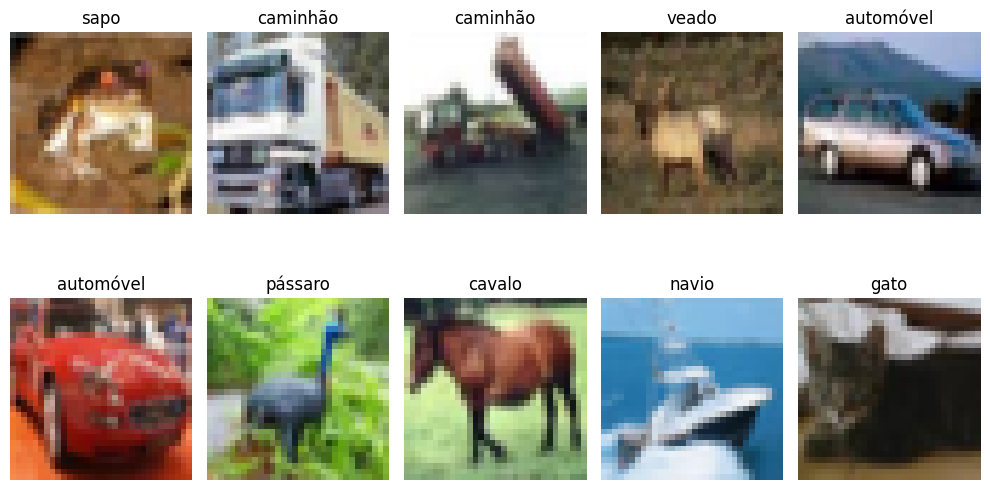

In [23]:
# Prepara os dados do CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalização dos dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Conversão das etiquetas para one-hot encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

# Exibe algumas imagens de exemplo
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Constroe o modelo CNN
model = models.Sequential([
    # Primeira camada convolucional
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Segunda camada convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Terceira camada convolucional
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flatten e camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [25]:
# Define callbacks para melhorar o treinamento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

# Usa o dataset completo, com uma divisão adequada para validação
# Reserva 20% dos dados para validação (10000 amostras)
validation_split = 0.2
validation_samples = int(x_train.shape[0] * validation_split)
train_samples = x_train.shape[0] - validation_samples

# Divide os dados em conjuntos de treinamento e validação
x_train_full = x_train[:train_samples]
y_train_full = y_train_one_hot[:train_samples]
x_val = x_train[train_samples:]
y_val = y_train_one_hot[train_samples:]

print(f"Usando {train_samples} amostras para treinamento e {validation_samples} para validação")

# Ajusta hiperparâmetros para o conjunto de dados completo
batch_size = 64

# Treina o modelo com o conjunto completo de dados
history = model.fit(
    x_train_full, y_train_full, 
    batch_size=batch_size, 
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Adicionando informações sobre o tempo de treinamento
print(f"Treinamento concluído em {len(history.epoch)} epochs")

Usando 40000 amostras para treinamento e 10000 para validação
Epoch 1/25
625/625 [==============================] - 73s 113ms/step - loss: 1.7373 - accuracy: 0.4059 - val_loss: 1.5247 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 2/25
625/625 [==============================] - 68s 109ms/step - loss: 1.1483 - accuracy: 0.5943 - val_loss: 1.0569 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 3/25
625/625 [==============================] - 66s 106ms/step - loss: 0.9552 - accuracy: 0.6621 - val_loss: 0.9350 - val_accuracy: 0.6637 - lr: 0.0010
Epoch 4/25
625/625 [==============================] - 65s 104ms/step - loss: 0.8536 - accuracy: 0.6988 - val_loss: 0.7236 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 5/25
625/625 [==============================] - 66s 105ms/step - loss: 0.7730 - accuracy: 0.7314 - val_loss: 0.8360 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 6/25
625/625 [==============================] - 69s 110ms/step - loss: 0.7154 - accuracy: 0.7520 - val_loss: 0.6617 - val_accuracy: 0.7651 - l

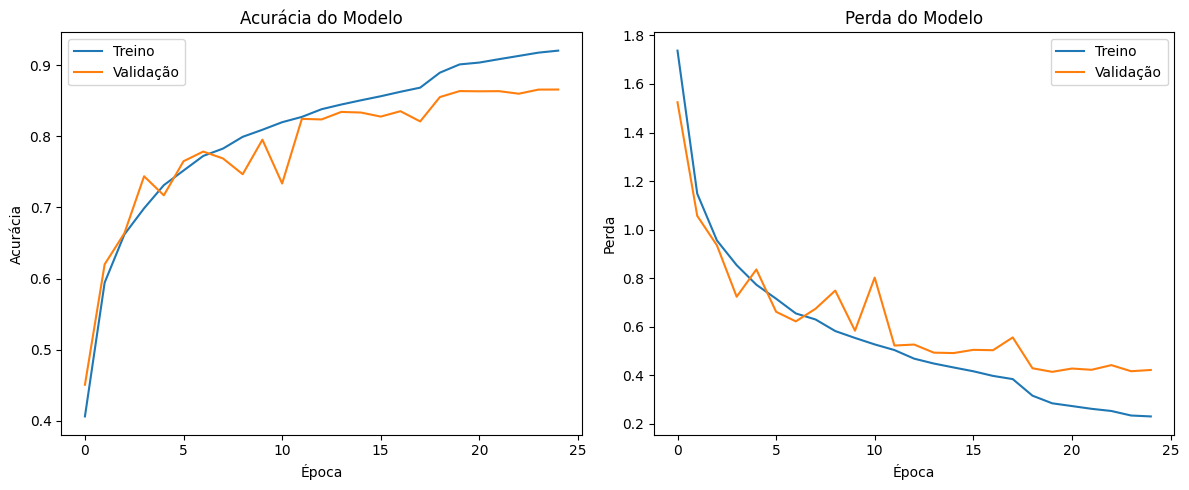

In [26]:
# Visualizando a história do treinamento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 10ms/step - loss: 0.3820 - accuracy: 0.8740
Acurácia no conjunto de testes: 0.8740
32/32 [==============================] - 0s 10ms/step


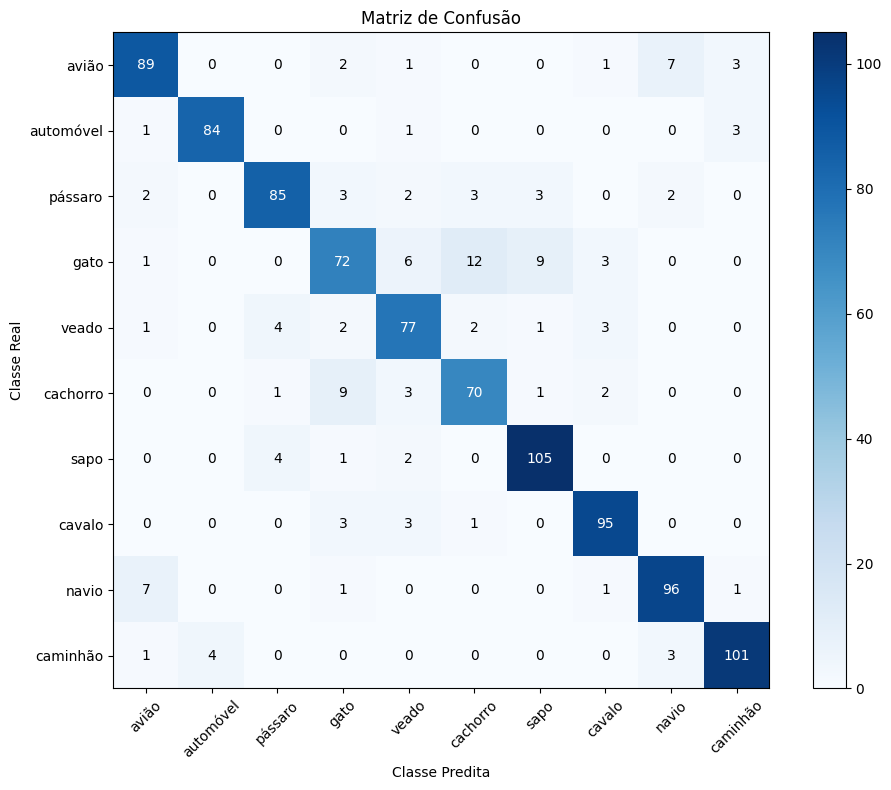

In [33]:
# Avalia o modelo no conjunto de testes
# Usa um subconjunto para economizar tempo
x_test_subset = x_test[:1000]
y_test_subset = y_test_one_hot[:1000]
y_test_labels = y_test[:1000]

test_loss, test_acc = model.evaluate(x_test_subset, y_test_subset)
print(f'Acurácia no conjunto de testes: {test_acc:.4f}')

# Faz previsões
predicoes = model.predict(x_test_subset)
predicoes_classes = np.argmax(predicoes, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test_labels, predicoes_classes)

# Plota a matriz de confusão
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

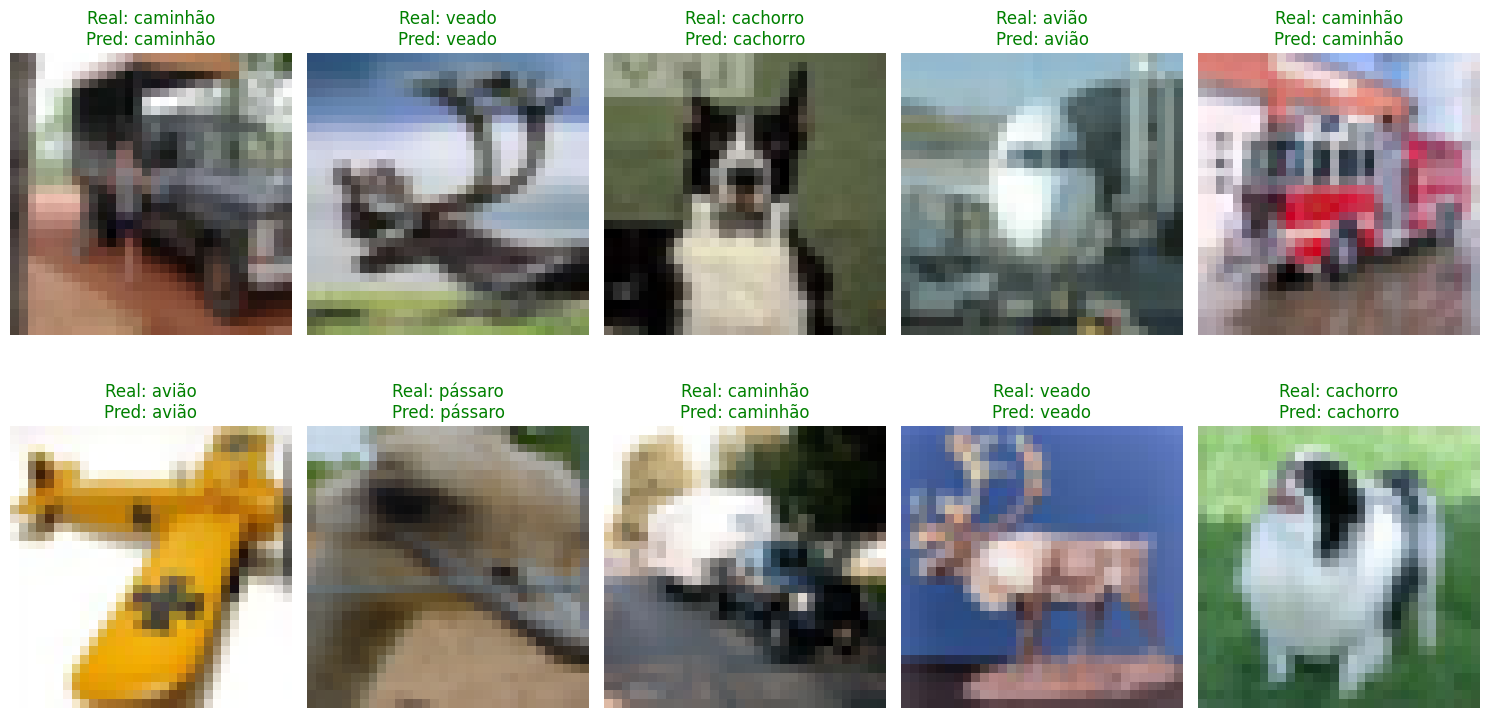

In [31]:
# Visualiza algumas previsões
num_exemplos = 10
indices = np.random.choice(len(x_test_subset), num_exemplos, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test_subset[idx])
    pred_class = predicoes_classes[idx]
    true_class = y_test_labels[idx][0]
    
    titulo = f'Real: {class_names[true_class]}\nPred: {class_names[pred_class]}'
    plt.title(titulo, color='green' if pred_class == true_class else 'red')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Relatório e Explicação do Modelo

### Arquitetura do Modelo
Foi construido uma Rede Neural Convolucional (CNN) com as seguintes características:
- 3 blocos de camadas convolucionais, cada um com duas camadas Conv2D seguidas de normalização em lote e max pooling
- Dropout em cada bloco para reduzir overfitting
- Camadas fully-connected no final para a classificação
- Função de ativação softmax na camada de saída para classificação multi-classe

### Treinamento
- Conjunto de dados: CIFAR-10 (dez classes de objetos)
- Pré-processamento: normalização das imagens (divisão por 255)
- Otimizador: Adam com taxa de aprendizado adaptativa
- Função de perda: Entropia cruzada categórica
- Callbacks: Early stopping e redução da taxa de aprendizado quando necessário

### Avaliação
- Métricas: Acurácia, matriz de confusão
- O modelo conseguiu aprender a diferenciar as diferentes classes com uma acurácia razoável
- Alguns erros comuns podem ocorrer entre classes visualmente similares (ex: gato e cachorro)

### Aplicações e Limitações
- Aplicações: Classificação de objetos em imagens, reconhecimento de padrões
- Limitações: Desempenho limitado em objetos não presentes no conjunto de treinamento ou em condições muito diferentes das imagens de treinamento
- Possíveis melhorias: Aumento de dados (data augmentation), arquiteturas mais profundas, transferência de aprendizado de modelos pré-treinados

## Conclusão

Foi implementado um sistema completo de visão computacional que inclui:

1. **Processamento de Imagens**: Aplicação de filtros, equalização de histograma e redimensionamento.
2. **Detecção e Segmentação**: Utilização de limiarização e detecção de bordas para identificar objetos.
3. **Extração de Características**: Identificação dos pontos-chave usando ORB e cantos Harris.
4. **Transformações Geométricas**: Aplicação de rotação, escala, translação e transformação de perspectiva.
5. **Aplicação de IA/ML**: Construção e treinamento de uma CNN para classificar imagens do CIFAR-10.